# __Cleaning the Data Scraped from Craigslist Rental Listings__
### W. W. Supplee 2020

In [1]:
#!/usr/bin/python3

import getLivedata as gl
import visualizeData as cl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import re
%matplotlib inline

In [2]:
df = pd.read_parquet('data.parquet')

In [3]:
df.head()

,pid,date,neighborhood,title,bedrooms,bathrooms,sqft,url,price,attributes,latitude,longitude
0,7091649847,2020-03-11,Mountain View,"2br - 2/1, Park, Nature trail, Google access (...",2,1,950,https://sfbay.craigslist.org/pen/apa/d/mountai...,3020,applicat|apartmen|laundryi|nosmokin|carport|,37.395954,-122.067890
1,7091643626,2020-03-11,Daly City,Updated Condo close to Serramonte shopping center,1,1,717,https://sfbay.craigslist.org/pen/apa/d/daly-ci...,1705,catsareo|dogsareo|furnishe|condo|w/dinuni|nosm...,37.664634,-122.463684
2,7091648589,2020-03-11,San Mateo,3 Bedroom 3 Bath Condo Style Home (w/ Fireplac...,3,3,1425,https://sfbay.craigslist.org/pen/apa/d/san-mat...,5180,evchargi|applicat|catsareo|dogsareo|apartmen|w...,37.562354,-122.285813
3,7091647413,2020-03-11,San Mateo,Spacious 1st Floor 1Bed/1Bath w/ Hardwood Floo...,1,1,807,https://sfbay.craigslist.org/pen/apa/d/san-mat...,3330,applicat|dogsareo|apartmen|w/dinuni|nosmokin|a...,37.558650,-122.285651
4,7091646440,2020-03-11,San Mateo,Newly renovated 1st Floor 1Bed/1Bath w/ Hardwo...,1,1,807,https://sfbay.craigslist.org/pen/apa/d/san-mat...,3255,evchargi|applicat|catsareo|dogsareo|apartmen|w...,37.558650,-122.285651


In [20]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 12)
df.describe()

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude
count,1.943000...,1943.000000,1943.000000,1943.000000,1943.000000,1943.000000,1943.000000
mean,7.090444...,1.475553,1.268142,736.475553,3374.356665,37.413225,-121.890917
std,4.211263...,0.889517,0.567439,616.727085,1163.840715,1.930994,6.457793
min,7.072154...,0.000000,0.000000,-1.000000,1.000000,0.000000,-122.516742
25%,7.090416...,1.000000,1.000000,530.000000,2625.000000,37.420229,-122.340723
50%,7.091580...,1.000000,1.000000,730.000000,3200.000000,37.523385,-122.256761
75%,7.092793...,2.000000,2.000000,984.000000,3850.000000,37.576159,-122.131275
max,7.095435...,6.000000,5.000000,16220.00...,13000.00...,43.771094,0.000000


__While we're working to clean the data, let's work with a temporary copy of the dataframe:__

In [39]:
tf = df.copy()
tf['pets'] = tf.apply(lambda x : cl.PetsOK(x),axis=1)
tf['laundry'] = tf.apply(lambda x : cl.hasLaundry(x)>1,axis=1)
tf['parking'] = tf.apply(lambda x : cl.hasParking(x)>0,axis=1)
tf['EV_charging'] = tf.apply(lambda x : cl.hasEVcharging(x),axis=1)
print(tf)
tf.neighborhood.describe()

             pid        date neighborhood        title  bedrooms  bathrooms  \
0     7091649847  2020-03-11  Mountain...  2br - 2/...         2          1   
1     7091643626  2020-03-11    Daly City  Updated ...         1          1   
2     7091648589  2020-03-11    San Mateo  3 Bedroo...         3          3   
3     7091647413  2020-03-11    San Mateo  Spacious...         1          1   
4     7091646440  2020-03-11    San Mateo  Newly re...         1          1   
...          ...         ...          ...          ...       ...        ...   
1938  7093874868  2020-03-18  Redwood ...  Coming s...         2          1   
1939  7091469416  2020-03-18   San Carlos  Spacious...         2          1   
1940  7081045763  2020-03-18  Redwood ...  Spacious...         1          1   
1941  7081046003  2020-03-18   San Carlos  Spacious...         2          1   
1942  7078528319  2020-03-18  Redwood ...  2 Bed/1 ...         2          1   

      sqft          url  price   attributes   latit

count            1943
unique             27
top       Mountain...
freq              330
Name: neighborhood, dtype: object

In [40]:
tf.neighborhood.value_counts()

Mountain View             330
San Mateo                 285
Redwood City              243
Palo Alto                 208
Daly City                 168
Foster City               154
Menlo Park                111
Pacifica                   77
South San Francisco        69
Burlingame                 69
San Bruno                  64
Belmont                    48
Millbrae                   28
San Carlos                 24
Los Altos                  20
East Palo Alto              9
Half Moon Bay               8
Sunnyvale                   7
Brisbane                    4
Downtown Mountain View      3
Redwood Shores              3
Portola Valley              3
Atherton                    3
Coastside/Pescadero         2
Woodside                    1
Daly City, Ca               1
Missing                     1
Name: neighborhood, dtype: int64

__We can see already that some posts are either not on the peninsula (i.e. posted on the wrong forum) or otherwise outliers.  We will remove any category with <5 observations__    

In [41]:
byNeighborhood = tf.groupby('neighborhood')
outlier_index = byNeighborhood.filter(lambda x : len(x)<5).index
tf=tf.drop(outlier_index)
tf.neighborhood.value_counts()

Mountain View          330
San Mateo              285
Redwood City           243
Palo Alto              208
Daly City              168
Foster City            154
Menlo Park             111
Pacifica                77
Burlingame              69
South San Francisco     69
San Bruno               64
Belmont                 48
Millbrae                28
San Carlos              24
Los Altos               20
East Palo Alto           9
Half Moon Bay            8
Sunnyvale                7
Name: neighborhood, dtype: int64

In [42]:
tf.groupby('neighborhood').describe()

pid                                                      \
              count         mean          std          min          25%   
neighborhood                                                              
Belmont        48.0  7.091790...  3.679996...  7.073958...  7.091198...   
Burlingame     69.0  7.090081...  5.287280...  7.074058...  7.090344...   
Daly City     168.0  7.088649...  5.169957...  7.073035...  7.086652...   
East Palo...    9.0  7.092286...  1.500879...  7.088531...  7.092351...   
Foster City   154.0  7.091200...  3.570390...  7.073444...  7.090990...   
Half Moon...    8.0  7.086632...  4.920494...  7.079177...  7.083277...   
Los Altos      20.0  7.087006...  6.394309...  7.073907...  7.083669...   
Menlo Park    111.0  7.090647...  3.845569...  7.078649...  7.090686...   
Millbrae       28.0  7.089623...  4.538921...  7.074023...  7.088418...   
Mountain ...  330.0  7.090770...  3.867962...  7.073402...  7.090823...   
Pacifica       77.0  7.089810...  4.561178...  7.074153...  7.089134...   
Palo Alto     208.0  7.090640...  3.734681...  7.072154...  7.089179...   
Redwood City  243.0  7.090995...  3.988796...  7.073939...  7.090990...   
San Bruno      64.0  7.090283...  3.772609...  7.074124...  7.090457...   
San Carlos     24.0  7.091148...  3.347896...  7.081046...  7.090984...   
San Mateo     285.0  7.090287...  4.288396...  7.072203...  7.090250...   
South San...   69.0  7.090895...  3.390853...  7.078713...  7.090573...   
Sunnyvale       7.0  7.091898...  2.040844...  7.087270...  7.092650...   

                                                    bedrooms            \
                      50%          75%          max    count      mean   
neighborhood                                                             
Belmont       7.092199...  7.093658...  7.095435...     48.0  1.104167   
Burlingame    7.091866...  7.092851...  7.095423...     69.0  1.173913   
Daly City     7.090608...  7.091946...  7.095420...    168.0  1.416667   
East Palo...  7.092354...  7.093415...  7.093440...      9.0  0.777778   
Foster City   7.091640...  7.093351...  7.095416...    154.0  1.415584   
Half Moon...  7.087235...  7.089184...  7.093409...      8.0  1.125000   
Los Altos     7.088519...  7.091780...  7.095435...     20.0  1.600000   
Menlo Park    7.091596...  7.092830...  7.095419...    111.0  1.774775   
Millbrae      7.091356...  7.092430...  7.094370...     28.0  2.214286   
Mountain ...  7.091605...  7.092773...  7.095432...    330.0  1.369697   
Pacifica      7.091011...  7.092731...  7.095413...     77.0  1.103896   
Palo Alto     7.091570...  7.093344...  7.095428...    208.0  1.668269   
Redwood City  7.092066...  7.092887...  7.095420...    243.0  1.440329   
San Bruno     7.091164...  7.092107...  7.095397...     64.0  1.578125   
San Carlos    7.092006...  7.092434...  7.095395...     24.0  1.833333   
San Mateo     7.091601...  7.092356...  7.095431...    285.0  1.505263   
South San...  7.091474...  7.092823...  7.095421...     69.0  1.594203   
Sunnyvale     7.092654...  7.092687...  7.092689...      7.0  1.571429   

                                                 bathrooms            \
                   std  min  25%  50%   75%  max     count      mean   
neighborhood                                                           
Belmont       0.627036  0.0  1.0  1.0  1.00  3.0      48.0  1.166667   
Burlingame    0.821701  0.0  1.0  1.0  2.00  3.0      69.0  1.173913   
Daly City     0.924819  0.0  1.0  1.0  2.00  5.0     168.0  1.172619   
East Palo...  0.833333  0.0  0.0  1.0  1.00  2.0       9.0  0.888889   
Foster City   0.702017  0.0  1.0  1.0  2.00  4.0     154.0  1.279221   
Half Moon...  0.991031  0.0  0.0  1.5  2.00  2.0       8.0  1.000000   
Los Altos     1.095445  0.0  1.0  1.0  2.00  4.0      20.0  1.400000   
Menlo Park    1.084475  0.0  1.0  1.0  2.00  5.0     111.0  1.315315   
Millbrae      1.100745  1.0  1.0  2.0  3.00  5.0      28.0  1.464286   
Mountain ...  0.80442

__Some records have data that is too incomplete to be usable.  (That is, the post URL did not have any useful information).  These records are caused by listings that have subsequently been flagged or removed.  We should remove them from our data set.__

In [43]:
outliers_index = tf[tf['bathrooms'] == 0].index
print(len(outliers_index),"listings have been subsequently removed or are not able to be parsed.")

53 listings have been subsequently removed or are not able to be parsed.


In [44]:
tf=tf.drop(outliers_index)
tf.describe()

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude
count,1.869000...,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000
mean,7.090413...,1.470305,1.306581,718.953451,3354.276619,37.445421,-122.014678
std,4.207423...,0.875433,0.524215,478.418134,1087.304235,1.534005,5.229541
min,7.072154...,0.000000,1.000000,-1.000000,510.000000,0.000000,-122.516742
25%,7.090419...,1.000000,1.000000,530.000000,2625.000000,37.420103,-122.348690
50%,7.091565...,1.000000,1.000000,725.000000,3195.000000,37.521087,-122.256782
75%,7.092774...,2.000000,2.000000,950.000000,3845.000000,37.576811,-122.131275
max,7.095435...,5.000000,5.000000,4348.000000,11000.00...,37.873800,0.000000


__Being craigslist, some posts are duplicates!  In the case of duplicates, we always keep the latest post in case of a price change or correction.  Let's drop the duplicates:__

In [46]:
duplicateView=tf.loc[:,['pid','title','bedrooms']]
duplicateView.sort_values(['pid'],ascending=True,inplace=True,axis=0)
print(duplicateView[duplicateView[['title','bedrooms']].duplicated(keep=False) == True].describe())
duplicates=tf.loc[duplicateView[['title','bedrooms']].duplicated(keep='last') == True]
print(len(duplicates),"entries are duplicates and will be dropped")
tf=tf.drop(duplicates.index)


       pid  bedrooms
count  0.0       0.0
mean   NaN       NaN
std    NaN       NaN
min    NaN       NaN
25%    NaN       NaN
50%    NaN       NaN
75%    NaN       NaN
max    NaN       NaN
0 entries are duplicates and will be dropped


In [47]:
tf.describe() # Let's see how many rentals are left

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude
count,1.730000...,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000
mean,7.090426...,1.477457,1.312717,729.659538,3363.118497,37.462995,-122.067990
std,4.223095...,0.883504,0.530079,478.772714,1091.224548,1.315347,4.574728
min,7.072154...,0.000000,1.000000,-1.000000,510.000000,0.000000,-122.516742
25%,7.090342...,1.000000,1.000000,540.000000,2631.750000,37.423545,-122.352626
50%,7.091576...,1.000000,1.000000,739.500000,3200.000000,37.526175,-122.257267
75%,7.092795...,2.000000,2.000000,970.000000,3848.750000,37.577136,-122.133354
max,7.095435...,5.000000,5.000000,4348.000000,11000.00...,37.873800,0.000000


__Note that some places for rent do not have area provided in the listings (usually listed in square feet -- our "sqft" column), but they still have rental price and bedroom data that are worth keeping them around for some subgroup analyses.  But just how many are there?  Well, they are marked by the value__ `sqft=-1`, __so let's see:__

In [48]:
tf[tf['sqft']<540].sqft.value_counts()

-1      297
 500     19
 400     12
 511      8
 405      8
       ... 
 335      1
 385      1
 389      1
 395      1
 397      1
Name: sqft, Length: 38, dtype: int64

count    377.000000
mean      84.190981
std      167.328622
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max      490.000000
Name: sqft, dtype: float64

In [75]:
outliers_index=tf[tf['sqft']==-1].index
tf=tf.replace(-1,np.nan)
tf.at[tf['latitude']==0,'latitude']=np.nan
tf.at[tf['longitude']==0,'longitude']=np.nan
areaTable=tf.drop(outliers_index)
areaTable.describe()

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude
count,1.668000...,1668.000000,1668.000000,1371.000000,1668.00000,1666.000000,1666.000000
mean,7.090467...,1.409472,1.266787,828.388038,3278.18705,37.506523,-122.207368
std,4.172776...,0.804654,0.458395,260.237507,935.41473,0.329400,1.952569
min,7.072154...,0.000000,1.000000,200.000000,510.00000,26.045652,-122.516742
25%,7.090343...,1.000000,1.000000,652.000000,2625.00000,37.424616,-122.351481
50%,7.091588...,1.000000,1.000000,773.000000,3174.00000,37.530926,-122.257267
75%,7.092801...,2.000000,2.000000,1000.000000,3745.00000,37.577072,-122.134202
max,7.095435...,4.000000,3.000000,1570.000000,8500.00000,37.873800,-43.007027


__Let's look for outliers!  We will use the interquartile range method.__

In [76]:
IQR_sqft=tf.sqft.quantile(0.75) - tf.sqft.quantile(0.25)
IQR_sqft

348.0

In [77]:
tf[tf['sqft']<(tf.sqft.quantile(0.25)-1.5*IQR_sqft)].describe() # No low outliers

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
tf[tf['sqft']>(tf.sqft.quantile(0.75)+1.5*IQR_sqft)].describe() # How many outliers on the large side?

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude
count,4.000000...,4.00,4.00,4.00000,4.000000,4.000000,4.000000
mean,7.092630...,3.25,2.25,1539.00000,6305.000000,37.475003,-122.203382
std,2.710236...,0.50,0.50,22.16604,1486.954382,0.028722,0.022466
min,7.088625...,3.00,2.00,1523.00000,5200.000000,37.448638,-122.222471
25%,7.092138...,3.00,2.00,1523.00000,5620.000000,37.450909,-122.222471
50%,7.093799...,3.00,2.00,1531.50000,5760.000000,37.475759,-122.206040
75%,7.094291...,3.25,2.25,1547.50000,6445.000000,37.499853,-122.186950
max,7.094299...,4.00,3.00,1570.00000,8500.000000,37.499853,-122.178975


In [79]:
outliers_index = tf[tf['sqft']>(tf.sqft.quantile(0.75)+1.5*IQR_sqft)].index
tf.drop(outliers_index,inplace=True)
areaTable = tf.loc[tf['sqft']>0,:]
areaTable.describe()

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude
count,1.367000...,1367.000000,1367.000000,1367.000000,1367.000000,1365.000000,1365.000000
mean,7.090645...,1.389173,1.271397,826.308705,3342.145574,37.505848,-122.244343
std,3.985026...,0.785558,0.457819,257.755283,894.212518,0.183525,0.218908
min,7.072154...,0.000000,1.000000,200.000000,510.000000,32.817800,-122.516742
25%,7.090519...,1.000000,1.000000,652.000000,2689.000000,37.417652,-122.325547
50%,7.091605...,1.000000,1.000000,772.000000,3250.000000,37.510311,-122.249472
75%,7.092806...,2.000000,2.000000,1000.000000,3845.000000,37.566748,-122.128174
max,7.095435...,4.000000,3.000000,1518.000000,6600.000000,37.707235,-116.922300


__It appears our data is right skewed in terms of rental property size, and we have dropped the extreme outliers (whiskers) that are >1.5 IQRs above the 75th percentile.__  

__Next let's check our data for any outliers geographically__

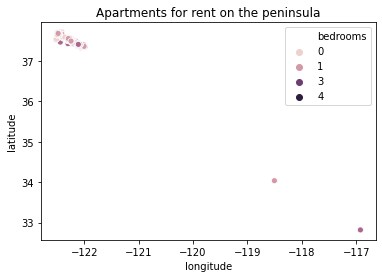

In [80]:
ax=sns.scatterplot(x='longitude',y='latitude',hue='bedrooms',data=areaTable)
ax.set_title('Apartments for rent on the peninsula')
plt.show()

Let's remove the apartments which are clearly NOT in our region!

In [82]:
outliersIndex = tf[tf['longitude']>-121].index
tf.drop(outliersIndex,inplace=True)
areaTable = tf.loc[tf['sqft']>0,:]
areaTable.describe()

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude
count,1.365000...,1365.000000,1365.000000,1365.000000,1365.000000,1363.000000,1363.000000
mean,7.090643...,1.389011,1.271795,826.043223,3345.569963,37.511834,-122.250993
std,3.987693...,0.785889,0.458037,257.850559,890.173193,0.093345,0.129899
min,7.072154...,0.000000,1.000000,200.000000,1000.000000,37.335807,-122.516742
25%,7.090517...,1.000000,1.000000,652.000000,2690.000000,37.417885,-122.325547
50%,7.091605...,1.000000,1.000000,770.000000,3250.000000,37.511112,-122.249472
75%,7.092807...,2.000000,2.000000,1000.000000,3845.000000,37.566748,-122.128635
max,7.095435...,4.000000,3.000000,1518.000000,6600.000000,37.707235,-121.984400


Let's try that plot again.

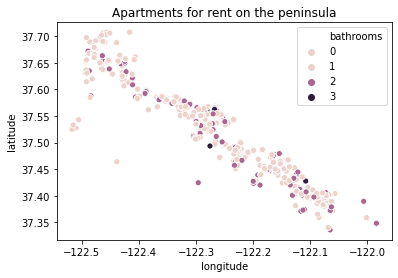

In [83]:
ax=sns.scatterplot(x='longitude',y='latitude',hue='bathrooms',data=areaTable)
ax.set_title('Apartments for rent on the peninsula')
plt.show()

__Next, let's create columns (of Boolean type) based on the attributes scraped from the listings.__

In [84]:
areaTable['$/sqft'] = areaTable.apply(lambda x : x.price/x.sqft,axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
pd.set_option('display.max_colwidth', 32)
LaundryList = tf.loc[:,['attributes','laundry']]

In [86]:
byLaundry = tf.groupby('laundry')
byLaundry.describe()

pid                                                          \
          count          mean           std           min           25%   
laundry                                                                   
False     539.0  7.089873e+09  4.666458e+06  7.072154e+09  7.088304e+09   
True     1122.0  7.090753e+09  3.875971e+06  7.072203e+09  7.090809e+09   

                                                  bedrooms            \
                  50%           75%           max    count      mean   
laundry                                                                
False    7.091442e+09  7.092741e+09  7.095435e+09    539.0  1.243043   
True     7.091633e+09  7.092836e+09  7.095428e+09   1122.0  1.483957   

                                           bathrooms                           \
              std  min  25%  50%  75%  max     count      mean       std  min   
laundry                                                                         
False    0.755600  0.0  1.0  1.0  2.0  3.0     539.0  1.146568  0.359215  1.0   
True     0.809297  0.0  1.0  1.0  2.0  4.0    1122.0  1.321747  0.486068  1.0   

                              sqft                                        \
         25%  50%  75%  max  count        mean         std    min    25%   
laundry                                                                    
False    1.0  1.0  1.0  3.0  417.0  730.537170  221.933785  200.0  570.0   
True     1.0  1.0  2.0  3.0  948.0  868.053797  261.426293  225.0  693.0   

                                  price                                   \
           50%      75%     max   count         mean         std     min   
laundry                                                                    
False    700.0   850.00  1500.0   539.0  2873.359926  796.918289  1000.0   
True     792.0  1064.25  1518.0  1122.0  3466.991979  912.341582   680.0   

                                         latitude                       \
            25%     50%      75%     max    count       mean       std   
laundry                                                                  
False    2395.0  2730.0  3250.00  7000.0    538.0  37.517943  0.104824   
True     2795.0  3400.0  3973.75  7500.0   1121.0  37.518658  0.090286   

                                                               longitude  \
               min        25%        50%        75%        max     count   
laundry                                                                    
False    37.358808  37.408622  37.529939  37.627127  37.707235     538.0   
True     37.335807  37.439600  37.533100  37.572135  37.873800    1121.0   

                                                                               \
               mean       std         min         25%         50%         75%   
laundry                                                                         
False   -122.261832  0.148152 -122.516742 -122.418373 -122.255778 -122.127400   
True    -122.259914  0.123291 -122.514832 -122.332399 -122.263048 -122.154239   

                     
                max  
laundry              
False   -122.001532  
True    -121.984400

__We want to create a model which can predict price.  Let's use a heatmap to see which statistics are most correlated.__

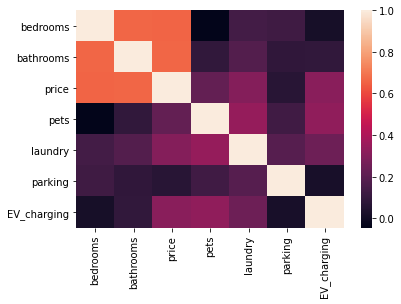

In [87]:
cl.generateHeatmap(tf,['neighborhood','bedrooms','bathrooms','price','pets','laundry','parking','EV_charging'])

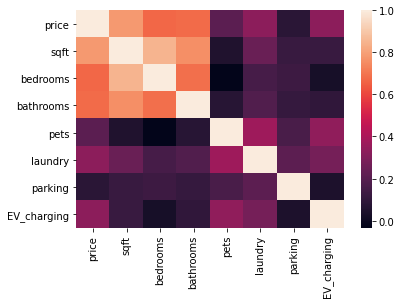

In [88]:
cl.generateHeatmap(areaTable,['price','sqft','bedrooms','bathrooms','pets','laundry','parking','EV_charging'])

__Finally, let's look at some descriptive statistics__

/home/supplee/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


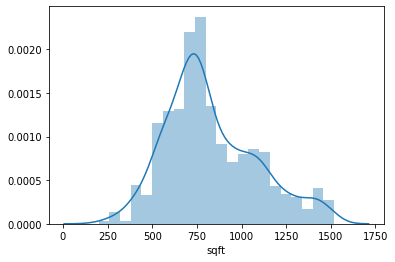

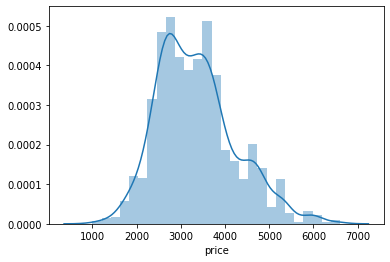

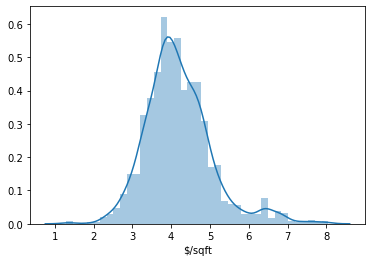

<Figure size 432x288 with 0 Axes>

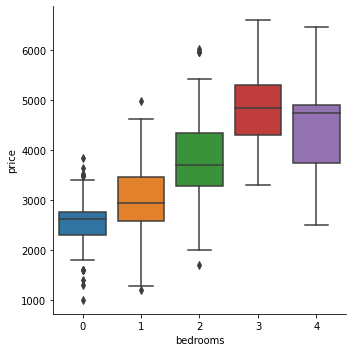

<Figure size 432x288 with 0 Axes>

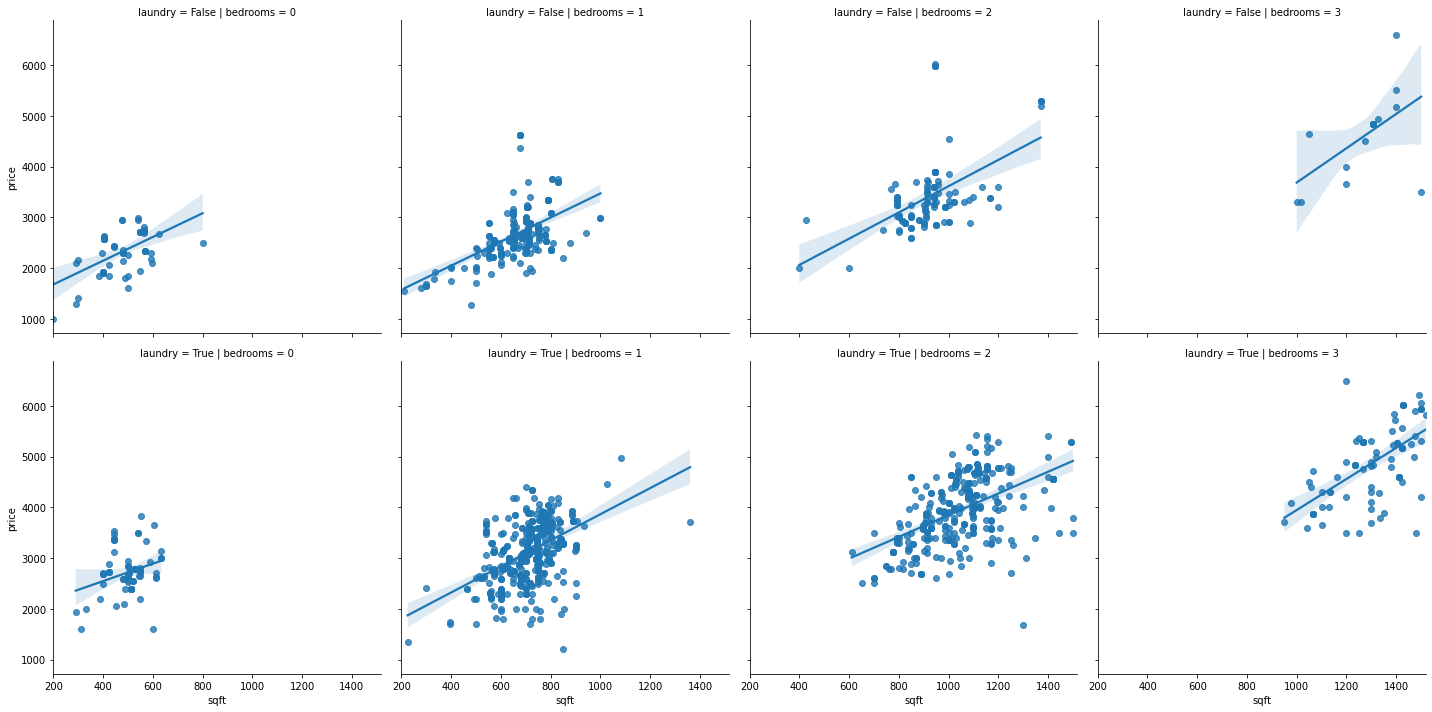

In [92]:
fig1=sns.distplot(areaTable.sqft)
plt.figure()
fig2=sns.distplot(areaTable.price)
plt.figure()
fig4=sns.distplot(areaTable['$/sqft'])
plt.figure()
fig3=sns.catplot(kind='box',x='bedrooms',y='price',data=areaTable)
plt.figure()
outliersIndex = areaTable[areaTable['sqft']>2500].index
areaTable.drop(outliersIndex,inplace=True)
reg=sns.lmplot(x='sqft',y='price',row='laundry',col='bedrooms',data=areaTable[areaTable['bedrooms']<4])

In [94]:
from scipy import stats

In [95]:
# get coeffs of linear fit by presence of absence of laundry
pslope1, pets_intercept1, petsr_value1, p_value1,std_err1 = stats.linregress(areaTable[areaTable['pets']==1].sqft,areaTable[areaTable['pets']==1].price)
pslope0, pets_intercept0, petsr_value0, p_value0,std_err0 = stats.linregress(areaTable[areaTable['pets']==0].sqft,areaTable[areaTable['pets']==0].price)
lslope1, laundry_intercept1, laundryr_value1, p_value1,std_err1 = stats.linregress(areaTable[areaTable['laundry']==1].sqft,areaTable[areaTable['laundry']==1].price)
lslope0, laundry_intercept0, laundryr_value0, p_value0,std_err0 = stats.linregress(areaTable[areaTable['laundry']==0].sqft,areaTable[areaTable['laundry']==0].price)


In [96]:
print("Apartments with pets allowed: ",end='')
print("price = ",pslope1,"* (sqft) +",pets_intercept1,"\nr =",petsr_value1,"r2 =",petsr_value1**2)
print("Apartments without pets allowed: ",end='')
print("price = ",pslope0,"* (sqft) +",pets_intercept0,"\nr =",petsr_value0,"r2 =",petsr_value0**2)
print("Apartments with laundry inside: ",end='')
print("price = ",lslope1,"* (sqft) +",laundry_intercept1,"\nr =",laundryr_value1,"r2 =",laundryr_value1**2)
print("Apartments without laundry inside: ",end='')
print("price = ",lslope0,"* (sqft) +",laundry_intercept0,"\nr =",laundryr_value0,"r2 =",laundryr_value0**2)

Apartments with pets allowed: price =  2.8195258051263967 * (sqft) + 1138.0089643846113 
r = 0.8129493320009061 r2 = 0.6608866164007196
Apartments without pets allowed: price =  2.4869519755605776 * (sqft) + 1100.545315920406 
r = 0.7631376748325545 r2 = 0.5823791107488376
Apartments with laundry inside: price =  2.5439329304404 * (sqft) + 1333.584844458479 
r = 0.7713556028786198 r2 = 0.594989466092239
Apartments without laundry inside: price =  2.6922870809745074 * (sqft) + 932.5223438235296 
r = 0.7597190021603996 r2 = 0.5771729622435932


__We see laundry and/or pets allowed in the apartment offers similar pricing per square foot, but with an increase in the intercept on the price axis.__

### __We can interpret that as a flat increase in the rent for these features__ 

__Let's quantify it:__

In [97]:
print("Allowing pets in the unit or building adds $%.2f to your rent each month" % float(pets_intercept1-pets_intercept0))
print("Allowing laundry in the unit or building adds $%.2f to your rent each month" % float(laundry_intercept1-laundry_intercept0))
laundryValue = laundry_intercept1 - laundry_intercept0
petsValue = pets_intercept1 = pets_intercept0

Allowing pets in the unit or building adds $37.46 to your rent each month
Allowing laundry in the unit or building adds $401.06 to your rent each month


In [185]:
import statsmodels.api as sm
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
areaNumbers = tf.loc[tf['sqft']>0,['bathrooms','sqft','pets','laundry','parking','EV_charging','price']]
#np_scaled = min_max_scaler.fit_transform(areaNumbers)
areaTable_normalized = pd.DataFrame(areaNumbers,columns=areaNumbers.columns)
areaTable_normalized['sqft_sqrt'] = areaTable_normalized.apply(lambda x : x.sqft**(1),axis=1)
X=np.array(areaTable_normalized[['bathrooms','sqft_sqrt','pets','laundry','parking','EV_charging']], dtype=float)
X=sm.add_constant(X,prepend=True)
y=np.array(areaTable_normalized['price'],dtype=float)
model=sm.OLS(y,X).fit()
predictions=model.predict(X)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     535.1
Date:                Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                        00:46:38   Log-Likelihood:                -10379.
No. Observations:                1365   AIC:                         2.077e+04
Df Residuals:                    1358   BIC:                         2.081e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        964.8086     49.160     19.626      0.000     868.372    1061.246
x1           383.1505     44.230      8.663      0.000     296.384     469.917
x2             2.0490      0.080     25.659      0.000       1.892       2.206
x3           143.6885     30.376      4.730      0.000      84.099     203.278
x4           152.9188     32.489      4.707      0.000      89.185     216.652
x5          -108.3178     30.635     -3.536      0.000    -168.415     -48.221
x6           431.7317     35.536     12.149      0.000     362.021     501.443
==============================================================================
Omnibus:                      110.387   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              525.334
Skew:                           0.196   Prob(JB):                    8.42e-115
Kurtosis:                       6.014   Cond. No.                     3.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [186]:
#predictions=predictions*(areaTable.price.max()-areaTable.price.min())
areaTable['predicted'] = predictions
print(areaTable)

             pid        date   neighborhood                            title  \
0     7091649847  2020-03-11  Mountain View  2br - 2/1, Park, Nature trai...   
1     7091643626  2020-03-11      Daly City  Updated Condo close to Serra...   
2     7091648589  2020-03-11      San Mateo  3 Bedroom 3 Bath Condo Style...   
3     7091647413  2020-03-11      San Mateo  Spacious 1st Floor 1Bed/1Bat...   
4     7091646440  2020-03-11      San Mateo  Newly renovated 1st Floor 1B...   
...          ...         ...            ...                              ...   
1932  7093607839  2020-03-18      San Mateo  Furnished, Convenient San Ma...   
1933  7095356752  2020-03-18      Palo Alto  LAST Large Patio+6 Weeks Ren...   
1934  7095368330  2020-03-18      Daly City  Urban Energy, Sky High Decad...   
1935  7095367497  2020-03-18   Redwood City  These Deals Wont Last Long 2...   
1936  7095366807  2020-03-18  Mountain View  Spacious 2 Bedroom/2 Bath Cl...   

      bedrooms  bathrooms    sqft      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [187]:
areaTable['residual'] = areaTable.apply(lambda x : x.price-x.predicted,axis=1)
print(areaTable)

             pid        date   neighborhood                            title  \
0     7091649847  2020-03-11  Mountain View  2br - 2/1, Park, Nature trai...   
1     7091643626  2020-03-11      Daly City  Updated Condo close to Serra...   
2     7091648589  2020-03-11      San Mateo  3 Bedroom 3 Bath Condo Style...   
3     7091647413  2020-03-11      San Mateo  Spacious 1st Floor 1Bed/1Bat...   
4     7091646440  2020-03-11      San Mateo  Newly renovated 1st Floor 1B...   
...          ...         ...            ...                              ...   
1932  7093607839  2020-03-18      San Mateo  Furnished, Convenient San Ma...   
1933  7095356752  2020-03-18      Palo Alto  LAST Large Patio+6 Weeks Ren...   
1934  7095368330  2020-03-18      Daly City  Urban Energy, Sky High Decad...   
1935  7095367497  2020-03-18   Redwood City  These Deals Wont Last Long 2...   
1936  7095366807  2020-03-18  Mountain View  Spacious 2 Bedroom/2 Bath Cl...   

      bedrooms  bathrooms    sqft      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


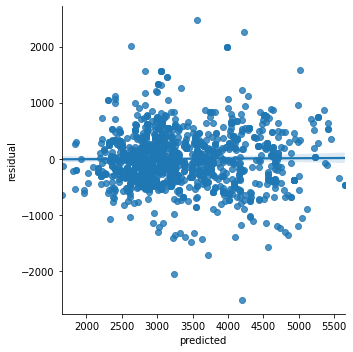

In [193]:
sns.lmplot(x='predicted',y='residual',data=areaTable[areaTable['bedrooms'] < 4])

__Well, that's it!  We have now assessed all the craigslist posts according to our multivariate model and the final column represents the 'residual' (actual price - predicted price).  The lower the residual (the more negative), the better our model thinks the craigslist asking price to be!  That is, listings where `pred_error < 0` are "good deals".  Posts where `pred_error` is two standard deviations or greater should be regarded as suspicious.__

In [194]:
tf.to_parquet('cleandata.parquet')
areaTable.to_parquet('cleanarea.parquet')
tf.to_csv('cleandata_debug.csv')
areaTable.to_csv('cleanarea_debug.csv')

In [195]:
areaTable.describe()

,pid,bedrooms,bathrooms,sqft,price,latitude,longitude,$/sqft,predicted,residual
count,1.365000e+03,1365.000000,1365.000000,1365.000000,1365.000000,1363.000000,1363.000000,1365.000000,1365.000000,1.365000e+03
mean,7.090643e+09,1.389011,1.271795,826.043223,3345.569963,37.511834,-122.250993,4.193504,3345.569963,-8.944497e-11
std,3.987693e+06,0.785889,0.458037,257.850559,890.173193,0.093345,0.129899,0.868127,746.240963,4.853172e+02
min,7.072154e+09,0.000000,1.000000,200.000000,1000.000000,37.335807,-122.516742,1.300000,1649.447392,-2.514870e+03
25%,7.090517e+09,1.000000,1.000000,652.000000,2690.000000,37.417885,-122.325547,3.658333,2798.170391,-2.831815e+02
50%,7.091605e+09,1.000000,1.000000,770.000000,3250.000000,37.511112,-122.249472,4.095000,3157.031479,-2.697823e+01
75%,7.092807e+09,2.000000,2.000000,1000.000000,3845.000000,37.566748,-122.128635,4.640381,3794.261750,2.702592e+02
max,7.095435e+09,4.000000,3.000000,1518.000000,6600.000000,37.707235,-121.984400,8.056667,5654.149376,2.465875e+03
